In [17]:
# google vision import
import os
import sys
from google.auth.transport.requests import Request, AuthorizedSession
from google.cloud.vision import ImageAnnotatorClient, types
from google.oauth2 import id_token, credentials, service_account
import pandas

credent = service_account.Credentials.from_service_account_file(
    'anster-1593361678608.json')

def localize_objects(path):
    """Localize objects in the local image.

    Args:
    path: The path to the local file.
    """
    from google.cloud import vision
    client = vision.ImageAnnotatorClient(credentials=credent)

    with open(path, 'rb') as image_file:
        content = image_file.read()
    image = vision.types.Image(content=content)

    objects = client.object_localization(
        image=image).localized_object_annotations
    
#     print('Number of objects found: {}'.format(len(objects)))
#     for object_ in objects:
#         print('\n{} (confidence: {})'.format(object_.name, object_.score))
#         print('Normalized bounding polygon vertices: ')
#         for vertex in object_.bounding_poly.normalized_vertices:
#             print(' - ({}, {})'.format(vertex.x, vertex.y))
            
    return objects

def location_preprocess(objects):
    object_array = [] 
    obj_count = len(objects) #計算有幾個object
    for object_ in objects:
        object_dict = {}
        
        #取得物件和可信度
        name = object_.name
        score = object_.score
        
        #取得座標
        location = object_.bounding_poly.normalized_vertices
        location_array = [location[0].x, location[0].y , location[2].x, location[2].y]
        
        
        #回傳值處理
        object_dict['name'] = name
        object_dict['score'] = score
        object_dict['location'] = location_array
        
        object_array.append(object_dict)
    
    return object_array

In [23]:
objects = localize_objects('ocean2.jpg')

object_array = location_preprocess(obj)
print(object_location_array)

[{'name': 'Person', 'score': 0.8949168920516968, 'location': [0.3740502893924713, 0.07796920090913773, 0.5554630160331726, 0.5977292656898499]}, {'name': 'Person', 'score': 0.8839148283004761, 'location': [0.06714311987161636, 0.2734234035015106, 0.14747413992881775, 0.4500562846660614]}, {'name': 'Shorts', 'score': 0.6374115347862244, 'location': [0.38776424527168274, 0.3478175699710846, 0.5563060641288757, 0.48119452595710754]}]


### Final Function

In [33]:
def color_detection(objects, file_name):
    #把物件、可信度、物件位置抓出來
    object_array = location_preprocess(objects)
    
    #針對每個物件增加顏色array
    for object_ in object_array: #遍歷照片中的每個物件
        hex_code_array = find_dominate_color(file_name, object_['location']) #取得顏色號碼陣列
        print(hex_code_array)
        
    return hex_code_array



C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: scipy.product is deprecated and will be removed in SciPy 2.0.0, use numpy.product instead
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: scipy.histogram is deprecated and will be removed in SciPy 2.0.0, use numpy.histogram instead
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead


['#e9e9e8', '#b0a18f', '#2d241d', '#b8cad0', '#936140']
['#907452', '#a2b1af', '#433724', '#c59e76', '#c2d4de']
['#8d593f', '#9e8d80', '#e7e8e7', '#383333', '#c3bfba']


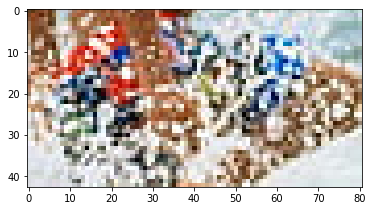

In [38]:
file_name = 'ocean2.jpg'

objects = localize_objects(file_name) #bob的function

hex_code_array = color_detection(objects, file_name)



### 顏色偵測

In [3]:
# 顏色偵測
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster
from PIL import Image 
import matplotlib.pyplot as plt

In [37]:
def crop_image(file_name, location):
    
    img = Image.open(file_name)
    plt.imshow(img)
    #取得照片長寬
    width, height = img.size 
    
    #得出物件上下左右
    left = location[0] * width
    top = location[1] * height
    right = location[2] * width 
    bottom = location[3] * height
    
    #裁切
    crop_img = img.crop((left, top, right, bottom)) 

    plt.imshow(crop_img)
    return crop_img

def find_dominate_color(file_name, location, resize=False, color_nums=5):
    NUM_CLUSTERS = color_nums
    hex_code_array = []
    
    # 照片前處理
    try: 
        im = crop_image(file_name, location)
        if resize:
            print('start image resize to 150, 150')
            im = im.resize((150, 150))      # optional, to reduce time
        ar = np.asarray(im)
        shape = ar.shape
        ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    except Exception as e:
        print(f'Error: find_dominate_color preprocessing went wrong, exception:{e}')
        return []
    
    # 計算顏色
    try:
        codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
        vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
        counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

        index_max = scipy.argmax(counts)                    # find most frequent
        peak = codes[index_max]
        colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
    except Exception as e:
        print(f'Error: find_dominate_color clustering went wrong, exception:{e}')
              
#     print('most frequent is %s (#%s)' % (peak, colour))

    # 顏色編碼
    for i in codes:
        hex_code = '#'+binascii.hexlify(bytearray(int(c) for c in i)).decode('ascii')
        hex_code_array.append(hex_code)
        
    return hex_code_array

### 顏色處理

In [ ]:
#顏色處理
import webcolors
import matplotlib.colors as mc
def color_predefine():
    CSS3 = webcolors.CSS3_NAMES_TO_HEX
    CSS3_r = {}
    CSS3['brown'] = '#8B4513'
    CSS3['darkbrown'] = '#654321'
    CSS3['caramel'] = '#65350F'
    CSS3['coffee'] = '#6F4137'
    CSS3['darkcoffee'] = '#3B2F2F'
    
    for k, v in CSS3.items():
        CSS3_r[v] = k
        print(k,v)
    return CSS3, CSS3_r

CSS3, CSS3_r = color_predefine()

In [ ]:
def closest_color(requested_color):
    min_colors = {}
    
    #計算最相近的顏色
    try:
        rgb = webcolors.hex_to_rgb(requested_color)
        for key, value in CSS3.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(value)
            rd = (r_c - rgb[0]) ** 2
            gd = (g_c - rgb[1]) ** 2
            bd = (b_c - rgb[2]) ** 2
            min_colors[(rd + gd + bd)] = value
        nearest_color = min_colors[min(min_colors.keys())]
        name = CSS3_r[nearest_color]
        return name
    except Exception as e:
        print(f'Error: closest_color went wrong, exception {e}')
        return None
        
def get_color_name(requested_color, method:str = 'hex'):
    print(requested_color[0])
    try:
        
        if method == 'hex' and str(requested_color[0]) == '#':            
            closest_name = actual_name = CSS3_r[requested_color]
        else:
            closest_name = actual_name = webcolors.rgb_to_name(requested_color)
    except ValueError:
        closest_name = closest_color(requested_color)
        actual_name = None
    except Exception as e:
        closest_name = closest_color(requested_color)
        actual_name = None
        
    return actual_name, closest_name